# RR Lyrae Classification
Stephen Portillo

Based on code by Jake VanderPlas for [Figure 9.6](http://www.astroml.org/book_figures/chapter9/fig_rrlyrae_GMMbayes.html) of _Statistics, Data Mining, and Machine Learning in Astronomy_ (2020) by Ivezić, Connolly, Vanderplas, and Gray

Additional reading:
* [Jake VanderPlas's Python Data Science Handbook: Gaussian Mixture Models](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)
* [scikit-learn User Guide: Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html#classification)

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

In [2]:
# make the plots look nice
mpl.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')

## Dataset

AstroML gives us easy access to a dataset of photometric colors of SDSS standard stars and RR Lyrae stars confirmed by time series observations. Looking at [the documentation](https://www.astroml.org/modules/generated/astroML.datasets.fetch_rrlyrae_combined.html), we see that the four columns of `X` are the colors u-g, g-r, r-i, and i-z, and that `y` is 1 if the star is an RR Lyrae or a 0 if it is not. We have almost 100,000 stars to work with!

In [3]:
# fetch the data and print its dimensions
X, y = fetch_rrlyrae_combined()
features = ['u-g', 'g-r', 'r-i', 'i-z']
labels = ['non-variable', 'RR Lyrae']
print('X.shape', X.shape)
print('y.shape', y.shape)

X.shape (93141, 4)
y.shape (93141,)


It's always a good idea to check out what your data looks like - if there are only a few features, a corner plot can be a useful tool. [corner.py](https://corner.readthedocs.io/) makes nice corner plots, but doesn't allow you to color points based on their labels, while [Seaborn](https://seaborn.pydata.org/generated/seaborn.pairplot.html) does. But instead of adding another dependency to this notebook, I decided to make my own corner plot with `matplotlib`.

We see that the RR Lyrae occupy a somewhat distinct part of color space, so trying to find them based on color seems reasonable.

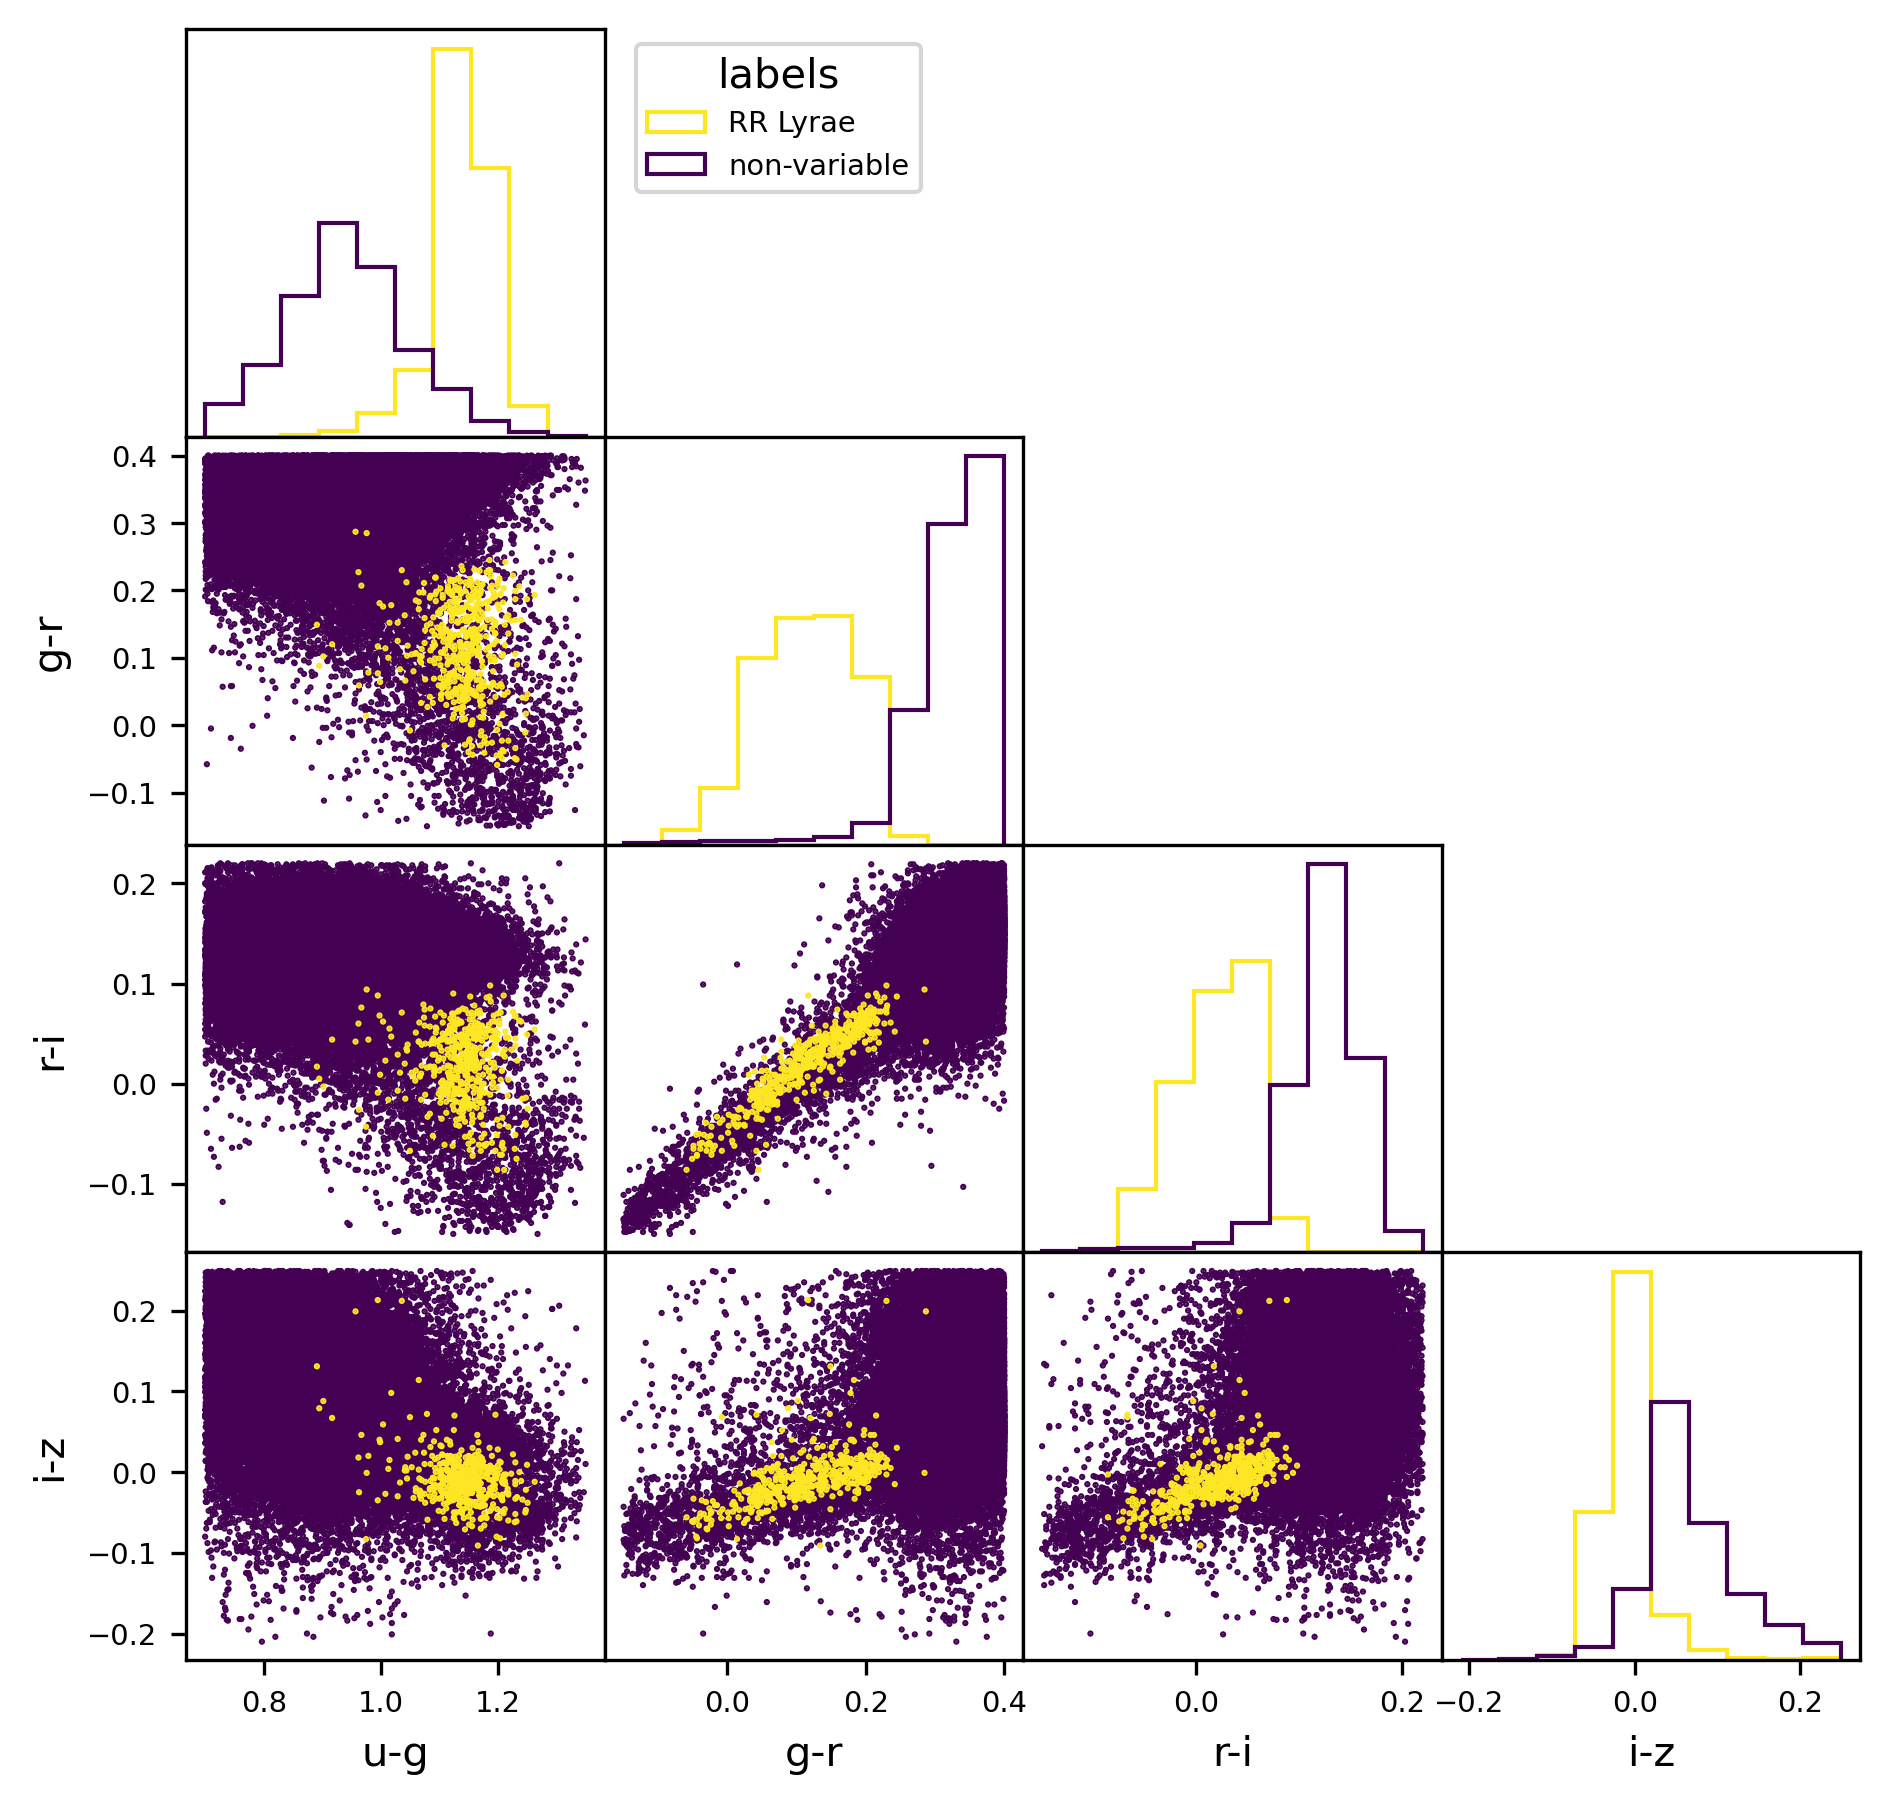

In [4]:
# make a corner plot
from matplotlib import cm
cmap = cm.get_cmap('viridis')

fig = plt.figure(figsize=(7.2,7.2))
fig.subplots_adjust(hspace=0, wspace=0)
# loop through every possible pair of features
for i in range(4):
    for j in range(4):
        # only make subplots in the lower diagonal
        if i <= j:
            plt.subplot(4,4,i+j*4+1)
            # if this subplot is on the left side (but not the top), make a y label
            if i == 0 and j != 0:
                plt.ylabel(features[j])
            # if this subplot is on the bottom, make an x label
            if j == 3:
                plt.xlabel(features[i])
            # remove ticks on interior plots
            if i != 0:
                plt.yticks([])
            if j != 3:
                plt.xticks([])
            # scatter plots in off diagonals
            if i < j:
                plt.scatter(X[:,i], X[:,j], s=1, marker='.', c=y, cmap=cmap)
            # normalized histograms on diagonals, with same colour map as scatter plots
            if i == j:
                plt.hist([X[y == 0, i], X[y == 1, i]], density=True, histtype='step',\
                         label=labels, color=[cmap(0.), cmap(1.)])
                plt.yticks([]) # don't want counts in the y-axis
                # add a legend
                if i == 0:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='labels')
plt.show()

We will split our dataset into a **training set** (80%), **validation set** (10%), and **test set** (10%). The validation set will allow us to do hyperparameter tuning for one method. The test set will allow us to compare different methods after hyperparameter tuning.

In [5]:
# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

## Gaussian Mixture Bayes Classifier

We'll model the distributions of both the non-variable stars (0) and the RR Lyrae (1) as Gaussian mixtures:

$$p(x\mid 0) \equiv p_0(x) = \sum_i \frac{w_{0,i}}{\lvert\Sigma_{0,i}\rvert^2 \left(2\pi\right)^{D/2}}
\exp \left[ - \frac{1}{2} (x - \mu_{0,i})^T \Sigma_{0,i} (x - \mu_{0,i}) \right] $$

$$p(x \mid 1) \equiv p_1(x) = \sum_i \frac{w_{1,i}}{\lvert\Sigma_{1,i}\rvert^2 \left(2\pi\right)^{D/2}}
\exp \left[ - \frac{1}{2} (x - \mu_{1,i})^T \Sigma_{1,i} (x - \mu_{1,i}) \right] $$

where $x$ is the vector of features and the number of features is $D=4$ in our case. Each gaussian has a mean $\mu$ and covariance matrix $\Sigma$, and the weights are normalized so that $\sum_i w_{0,i} = \sum_i w_{1,i} = 1.$ Here's an example of what a Gaussian mixture of two Gaussians looks like:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_gmm_pdf_001.png)

For the loss function, we'll use the negative log-likelihood of the data:

$$L = -\log \left(\prod_j p\left(x_j \mid \{ w_{0,i}, \mu_{0,i}, \Sigma_{0,i}\}, \{ w_{1,i}, \mu_{1,i}, \Sigma_{1,i}\} \right)\right) \\
= -\sum_j \log p\left(x_j \mid \{ w_{0,i}, \mu_{0,i}, \Sigma_{0,i}\}, \{ w_{1,i}, \mu_{1,i}, \Sigma_{1,i}\} \right) \\
= -\sum_{y_j = 0} \log p\left(x_j \mid \{ w_{0,i}, \mu_{0,i}, \Sigma_{0,i}\}\right) - \sum_{y_j = 1} \log p \left(x_j \mid \{ w_{1,i}, \mu_{1,i}, \Sigma_{1,i}\} \right) \\
= -\sum_{y_j = 0} \log p_0(x_j) - \sum_{y_j = 1} \log p_1(x_j)$$

where $y_j$ are the labels. So to minimize the loss function, we need to find the combination of $\{ w_{0,i}, \mu_{0,i}, \Sigma_{0,i}\}$ that maximizes the likelihood of the non-variable stars and $\{ w_{0,i}, \mu_{0,i}, \Sigma_{0,i}\}$ that maximizes the likelihood of the RR Lyrae.

Once the model is trained, we can use it to classify new stars by using Bayes' rule:

$$p(1 \mid x) = \frac{p(x \mid 1) p(1)}{p(x \mid 0) p(0) + p(x | 1) p(1)} = \frac{p_1(x) p(1)}{p_1(x) p(1) + p_0(x) p(0)}$$

which requires us to specify a prior $p(1)$ on how likely it is that a star is an RR Lyrae ($p(0) = 1-p(1)$ since there are only two classes). If we expect that we'll be using this classifier on data that is similar to the training set, using the fraction of RR Lyrae in the training data is a reasonable prior.

`astroML` makes it really easy to train a Gaussian Mixture Bayes Classifier - we just need to specify the number of Gaussian components to use for each class.

In [6]:
%%time
# train a Gaussian Mixture Bayes classifier with 3 gaussians for each class
clf_gmmb = GMMBayes(n_components=3, random_state=0)
clf_gmmb.fit(X_train, y_train)

CPU times: user 3.26 s, sys: 4.86 s, total: 8.12 s
Wall time: 2.17 s


GMMBayes(n_components=array([3]))

That didn't take long at all!

Visualizing the trained model in 4D is hard, so we'll settle for drawing 1D and 2D projections of it:

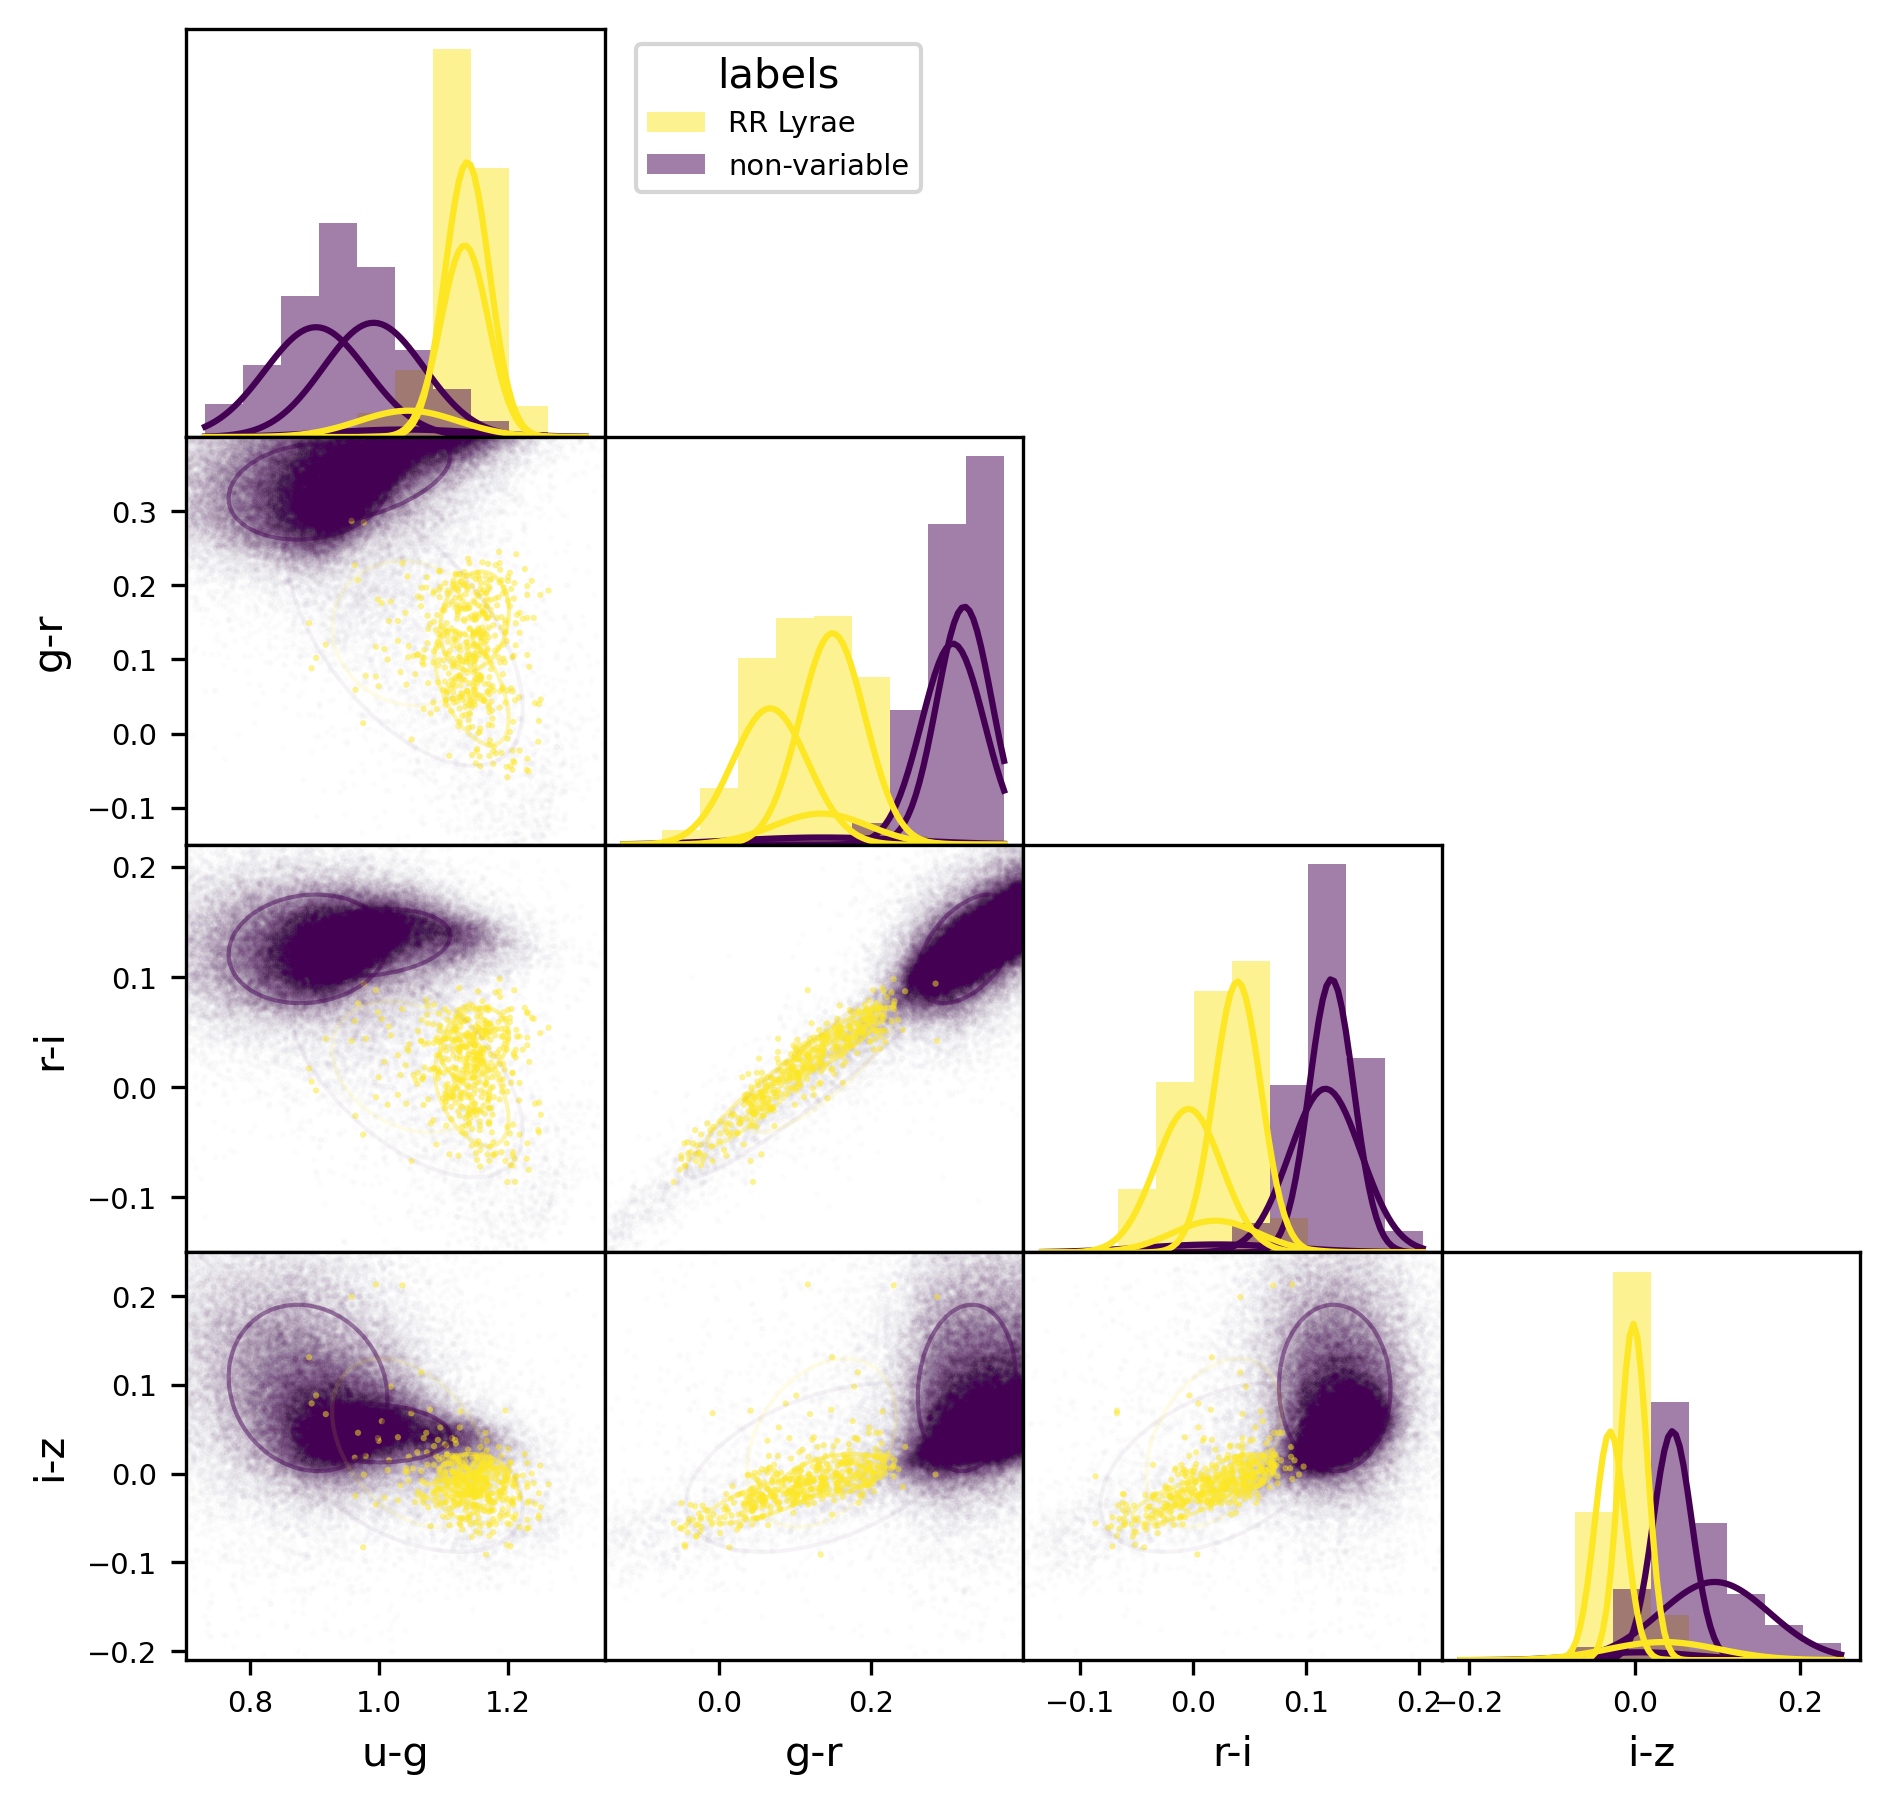

In [7]:
from scipy.stats import norm

fig = plt.figure(figsize=(7.2,7.2))
fig.subplots_adjust(hspace=0, wspace=0)

# loop through every possible pair of features
for i in range(4):
    for j in range(4):
        # only make subplots in the lower diagonal
        if i <= j:
            ax = plt.subplot(4,4,i+j*4+1)
            # if this subplot is on the left side (but not the top), make a y label
            if i == 0 and j != 0:
                ax.set_ylabel(features[j])
            # if this subplot is on the bottom, make an x label
            if j == 3:
                ax.set_xlabel(features[i])
            # remove ticks on interior plots
            if i != 0:
                ax.set_yticks([])
            if j != 3:
                ax.set_xticks([])
            # scatter plots in off diagonals
            if i < j:
                ax.scatter(X[y==0,i], X[y==0,j], s=1, marker='.', c=y[y==0], vmin=0, vmax=1, alpha=0.01)
                ax.scatter(X[y==1,i], X[y==1,j], s=1, marker='.', c=y[y==1], vmin=0, vmax=1, alpha=0.5)
                # adapted from "GMM Covariances"
                # https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
                idx = [i,j]
                rows = [[i, i], [j, j]]
                cols = [[i, j], [i, j]]
                for k in range(2): # for each class
                    for l in range(3): # for each Gaussian
                        covariances = clf_gmmb.gmms_[k].covariances_[l][rows, cols]
                        v, w = np.linalg.eigh(covariances)
                        u = w[0] / np.linalg.norm(w[0])
                        angle = np.arctan2(u[1], u[0])
                        angle = 180 * angle / np.pi  # convert to degrees
                        v = 2. * np.sqrt(2.) * np.sqrt(v)
                        ell = mpl.patches.Ellipse(clf_gmmb.gmms_[k].means_[l, idx], v[0], v[1],
                                                  180 + angle, ec=cmap(float(k)), fill=False)
                        #ell.set_clip_box(ax.bbox)
                        ell.set_alpha(clf_gmmb.gmms_[k].weights_[l])
                        ax.add_artist(ell)
                ax.set_xlim(np.min(X[:,i]), np.max(X[:,i]))
                ax.set_ylim(np.min(X[:,j]), np.max(X[:,j]))
            # normalized histograms on diagonals, with same colour map as scatter plots
            if i == j:
                plt.hist([X[y == 0, i], X[y == 1, i]], density=True, histtype='stepfilled',\
                         label=labels, color=[cmap(0.), cmap(1.)], alpha=0.5)
                
                plotx = np.linspace(np.min(X[:,i]), np.max(X[:,i]), 100)
                for k in range(2): # for each class
                    for l in range(3): # for each Gaussian
                        dist = norm(loc=clf_gmmb.gmms_[k].means_[l,i], scale=np.sqrt(clf_gmmb.gmms_[k].covariances_[l][i,i]))
                        plt.plot(plotx, clf_gmmb.gmms_[k].weights_[l] * dist.pdf(plotx), color=cmap(float(k)))
                
                plt.yticks([]) # don't want counts in the y-axis
                # add a legend
                if i == 0:
                    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='labels')
plt.show()

## Evaluating Classifier Performance

While the model is trained to minimize the loss function, we are probably more interested in the confusion matrix. Each star is put into one of the cells of the confusion matrix based on its true label (from the dataset) and its predicted label (from the model). scikit-learn again has a [convenience function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) that we will use to plot the **confusion matrix** for the validation set.

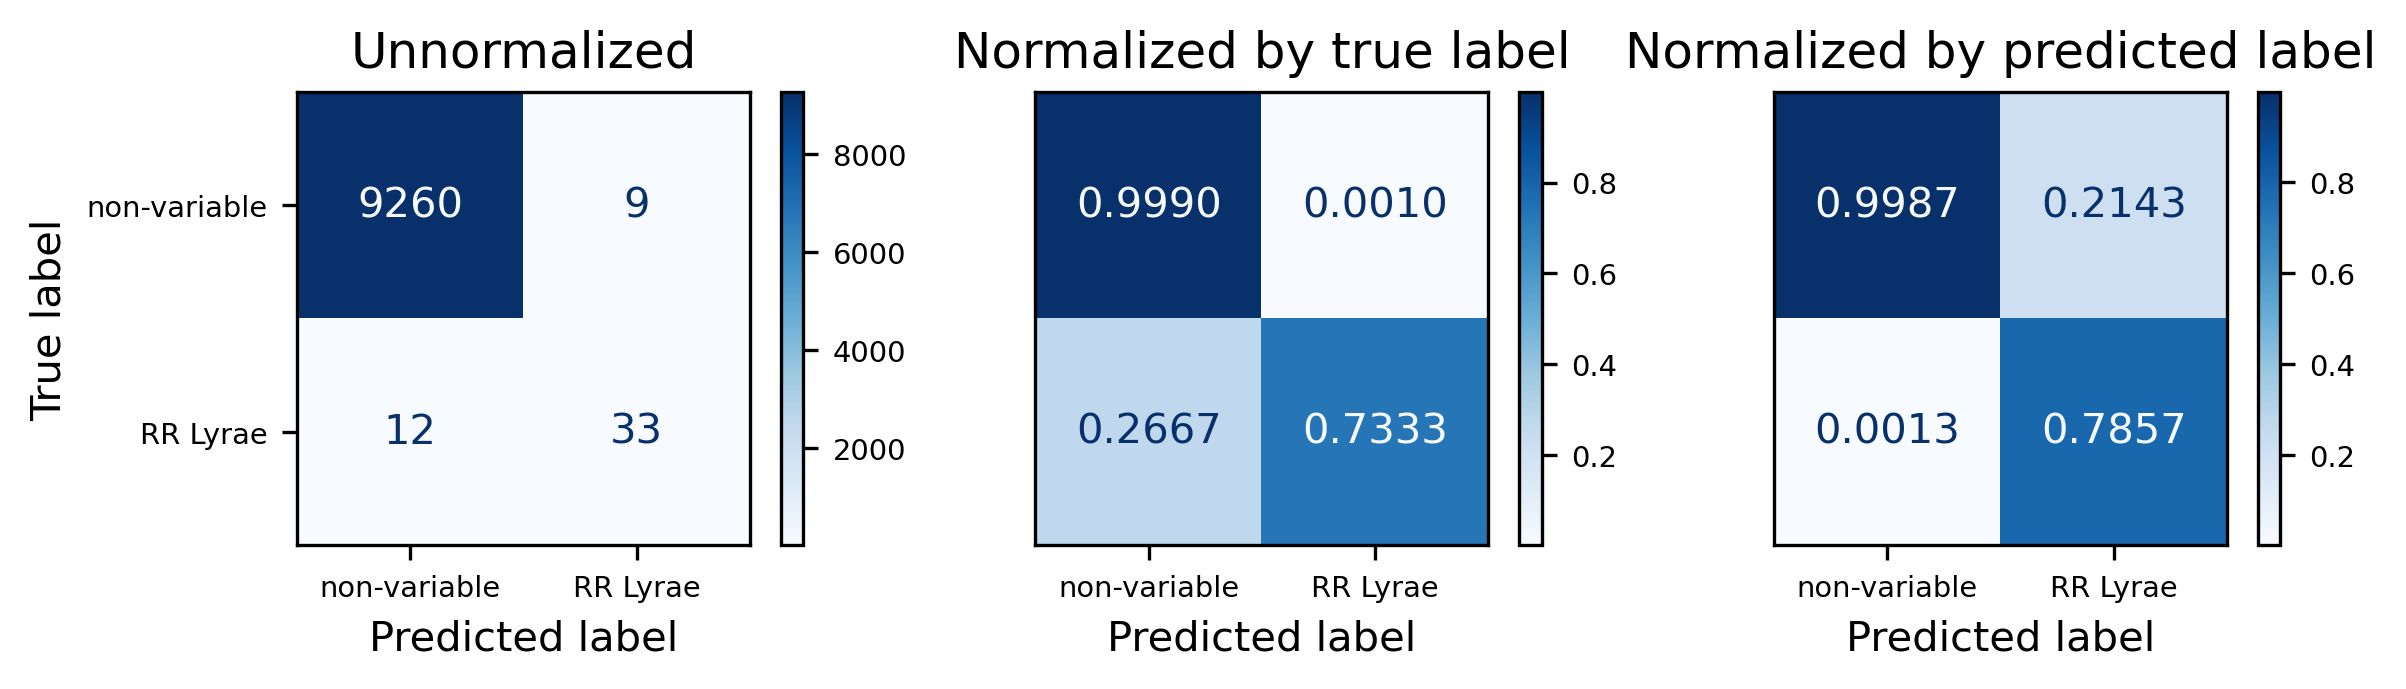

In [8]:
# plot the confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,2))

# unnormalized version
disp = plot_confusion_matrix(clf_gmmb, X_valid, y_valid, display_labels=labels, \
                      values_format='d', ax=ax[0], cmap='Blues')
disp.ax_.set_title('Unnormalized')

# normalized by true label
disp = plot_confusion_matrix(clf_gmmb, X_valid, y_valid, display_labels=labels, \
                      normalize='true', ax=ax[1], values_format='.4f', cmap='Blues')
disp.ax_.set_title('Normalized by true label')
disp.ax_.set_ylabel('')
disp.ax_.set_yticks([])

# normalized by predicted label
disp = plot_confusion_matrix(clf_gmmb, X_valid, y_valid, display_labels=labels, \
                      normalize='pred', values_format='.4f', ax=ax[2], cmap='Blues')
disp.ax_.set_title('Normalized by predicted label')
disp.ax_.set_ylabel('')
disp.ax_.set_yticks([])
plt.show()

The unnormalized confusion matrix is useful because it shows how many data points landed in each cell, but it can be harder to interpret when one class is rare, like the RR Lyrae in our case.

Instead, the confusion matrix is often normalized by the true label, meaning that each row adds up to 1, so we can see what fraction of stars with each true label ended up in each cell. We see that only 0.1% of the true non-variable stars were misclassified as RR Lyrae, while 73% of the true RR Lyrae were identified as RR Lyrae. Astronomers would say this classifier has a 73% **completeness** for RR Lyrae - a computer scientist would call this 73% **recall**.

Less commonly, the confusion matrix can by normalized by the predicted label, meaning that each column adds up to 1, so we can see what fraction of stars with each _predicted_ label ended up in each cell. We can see that even though only a tiny fraction of the true non-variable stars were misclassified, they comprise a significant fraction of the predicted RR Lyrae - 79%! An astronomer would say this classifier has 21% **contamination** - a computer scientist would call this 79% **precision**. 

## Hyperparameter Tuning

`scikit-learn` has built in functions to do [hyperparameter tuning](https://scikit-learn.org/stable/model_selection.html) based on a validation set, but we'll write out the code so we can see how it works. The **parameters** that we trained are the means $\mu$, covariances $\Sigma$, and weights $w$ of all the Gaussians. The most important **hyperparameter** is the number of Gaussian components.

Again, while the loss function is the negative log likelihood, we're more interested in the precision and recall. So let's train models with varying numbers of Gaussian components on the same training set, and see how they do on the validation set:

In [9]:
n_components  = range(1,6) # set of number of Gaussians we'll test

recall_valid = np.zeros(len(n_components))
precis_valid = np.zeros(len(n_components))

for i, n in enumerate(n_components):
    clf_gmmb = GMMBayes(n_components=n, random_state=0)
    clf_gmmb.fit(X_train, y_train)
    
    # calculate metrics for VALIDATION SET
    y_pred_valid = clf_gmmb.predict(X_valid)
    
    # count true positives
    tp_v = np.sum(np.logical_and(y_valid == 1, y_pred_valid == 1))
    # count false negatives
    fn_v = np.sum(np.logical_and(y_valid == 1, y_pred_valid == 0))
    # count false positives
    fp_v = np.sum(np.logical_and(y_valid == 0, y_pred_valid == 1))
    
    # calculate precision and recall
    recall_valid[i] = tp_v / (tp_v + fn_v)
    precis_valid[i] = tp_v / (tp_v + fp_v)

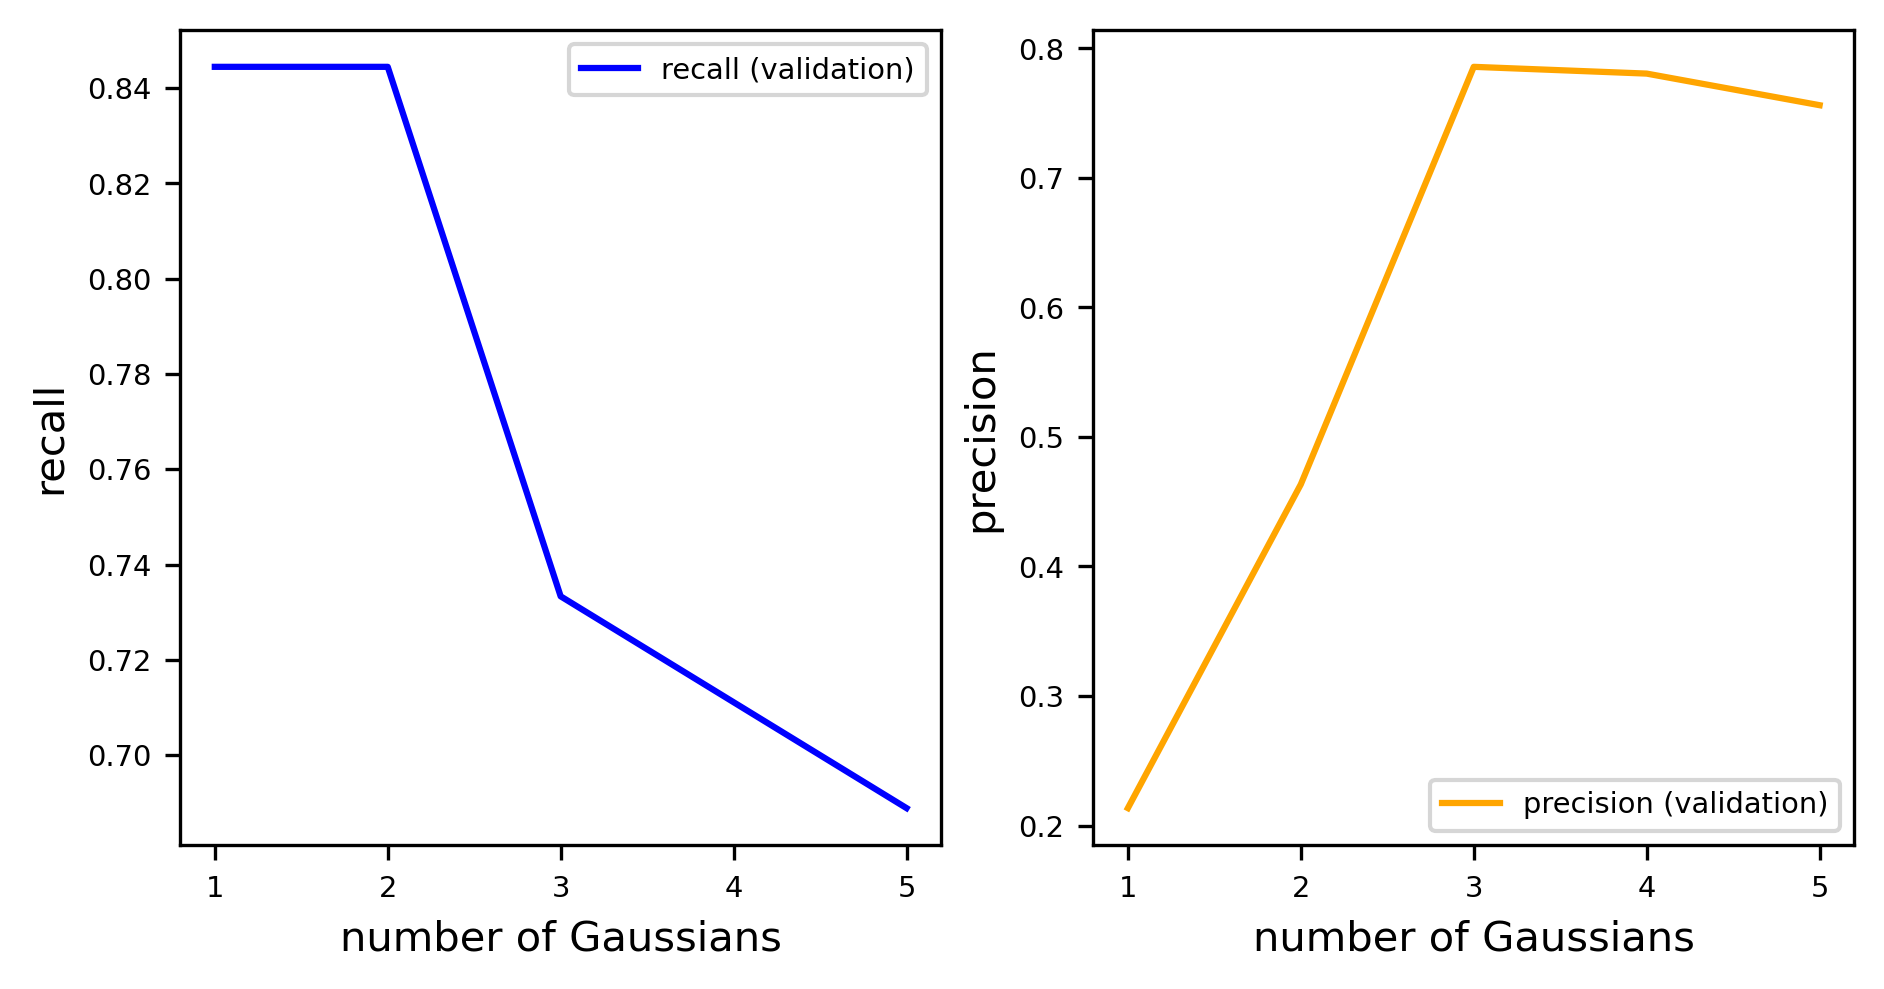

In [10]:
plt.figure(figsize=(7.2,3.6))
plt.subplot(1,2,1)
plt.plot(n_components, recall_valid, c='b', label='recall (validation)')
plt.ylabel('recall')
plt.xlabel('number of Gaussians')
plt.xticks(n_components)
plt.legend()
plt.subplot(1,2,2)
plt.plot(n_components, precis_valid, c='orange', label='precision (validation)')
plt.ylabel('precision')
plt.xlabel('number of Gaussians')
plt.xticks(n_components)
plt.legend()
plt.show()

If we wanted to maximize recall, 1 Gaussian is the best, while if we wanted to maximize precision, 5 seems to be the best, and it looks like more Gaussians would help. Depending on our goals, we might want to maximize some combination of precision and recall, with weights depending on how problematic false positives are compared to false negatives.

## k-Nearest Neighbors (kNN)

Some models don't have a conventional training process where a loss function is minimized by changing model parameters. An example is [k-nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html#classification), which makes predictions on new data in the following way:

1. Find the $k$ nearest neighbors to the given data point in the training set.
2. Classify the given data point as the majority class within the set of $k$ nearest neighbors.

But we can still do hyperparameter tuning on these sorts of models.

In [11]:
n_neighbors = range(1,12,2) # set of different k we'll test

recall_train = np.zeros(len(n_neighbors))
precis_train = np.zeros(len(n_neighbors))

recall_valid = np.zeros(len(n_neighbors))
precis_valid = np.zeros(len(n_neighbors))

for i, n in enumerate(n_neighbors):
    clf_knn = KNeighborsClassifier(n_neighbors=n)
    clf_knn.fit(X_train, y_train)
    
    # calculate metrics for TRAINING SET
    y_pred_train = clf_knn.predict(X_train)
    
    # count true positives
    tp_t = np.sum(np.logical_and(y_train == 1, y_pred_train == 1))
    # count false negatives
    fn_t = np.sum(np.logical_and(y_train == 1, y_pred_train == 0))
    # count false positives
    fp_t = np.sum(np.logical_and(y_train == 0, y_pred_train == 1))
    
    # calculate precision and recall
    recall_train[i] = tp_t / (tp_t + fn_t)
    precis_train[i] = tp_t / (tp_t + fp_t)
    
    # calculate metrics for VALIDATION SET
    y_pred_valid = clf_knn.predict(X_valid)
    
    # count true positives
    tp_v = np.sum(np.logical_and(y_valid == 1, y_pred_valid == 1))
    # count false negatives
    fn_v = np.sum(np.logical_and(y_valid == 1, y_pred_valid == 0))
    # count false positives
    fp_v = np.sum(np.logical_and(y_valid == 0, y_pred_valid == 1))
    
    # calculate precision and recall
    recall_valid[i] = tp_v / (tp_v + fn_v)
    precis_valid[i] = tp_v / (tp_v + fp_v)

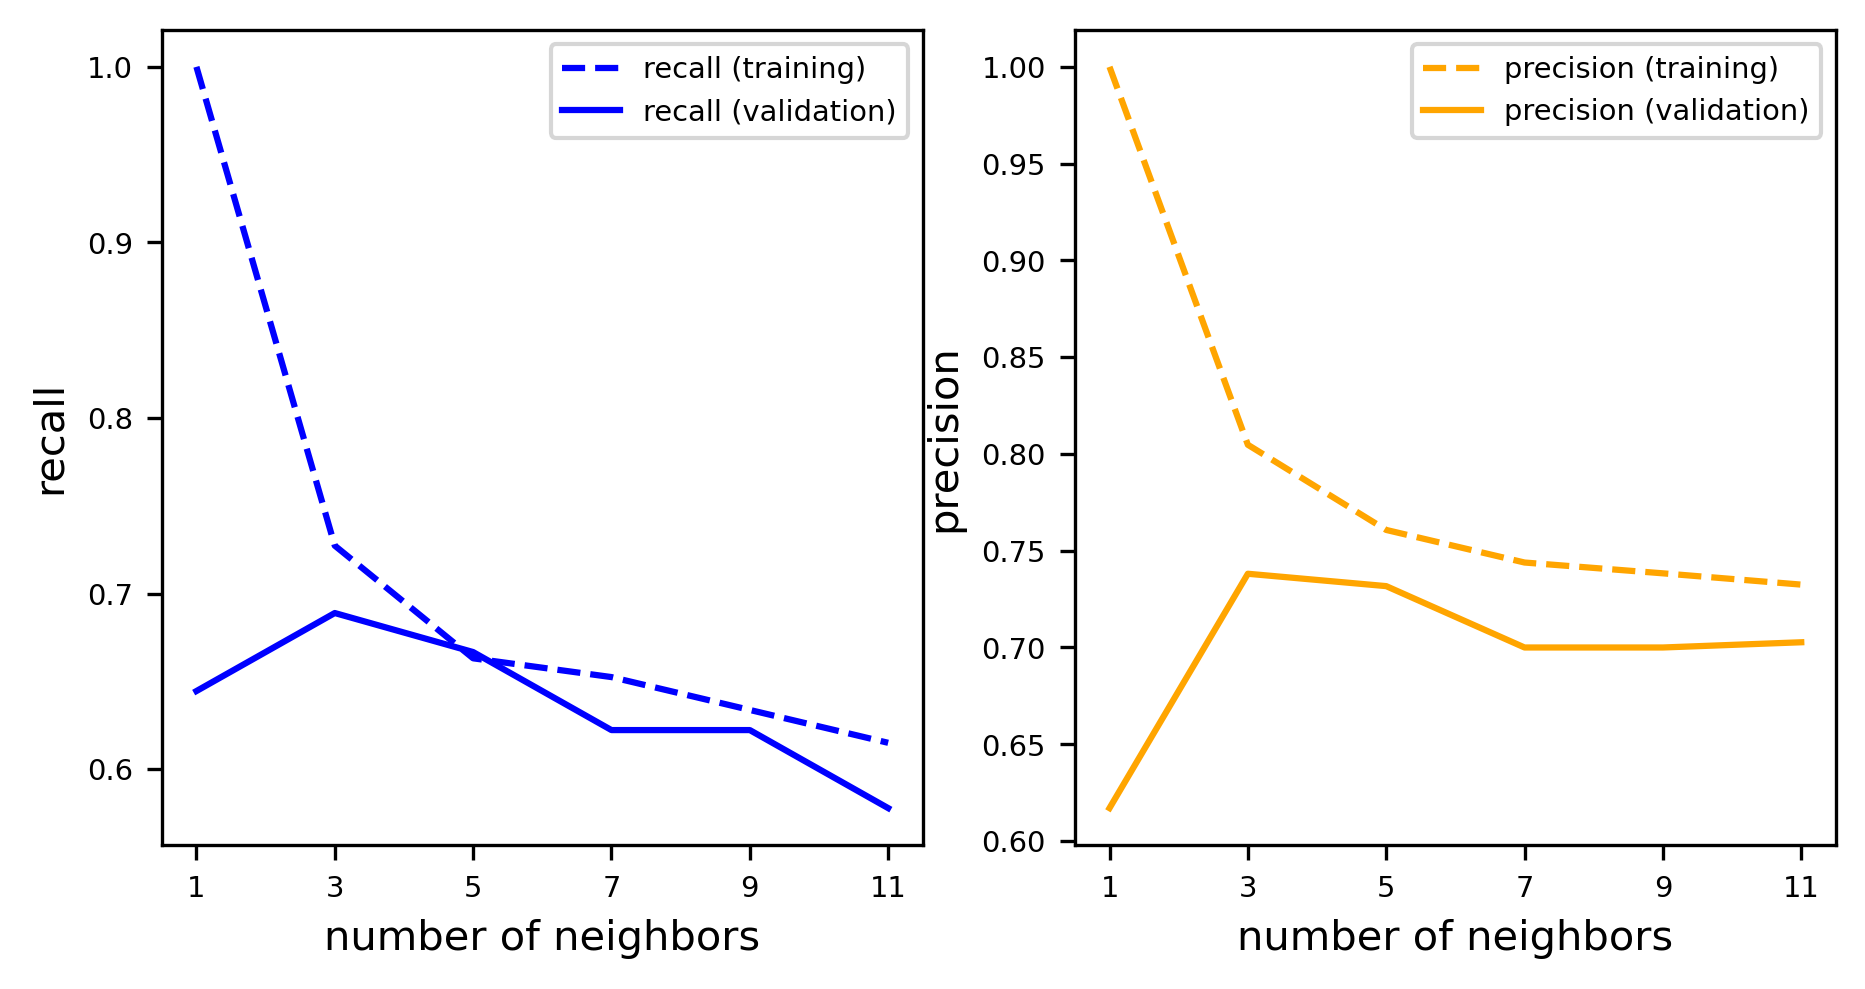

In [12]:
plt.figure(figsize=(7.2,3.6))
plt.subplot(1,2,1)
plt.plot(n_neighbors, recall_train, c='b', ls='--', label='recall (training)')
plt.plot(n_neighbors, recall_valid, c='b', label='recall (validation)')
plt.ylabel('recall')
plt.xlabel('number of neighbors')
plt.xticks(n_neighbors)
plt.legend()
plt.subplot(1,2,2)
plt.plot(n_neighbors, precis_train, c='orange', ls='--', label='precision (training)')
plt.plot(n_neighbors, precis_valid, c='orange', label='precision (validation)')
plt.ylabel('precision')
plt.xlabel('number of neighbors')
plt.xticks(n_neighbors)
plt.legend()
plt.show()

Note how the precision and recall are (usually) better on the training set than the validation set. When $k=1$ the model is **overfitting**: it does much on the training set than on the validation set.

## Things to try

Another hyperparameter in k-nearest neighbors is the power that is used to calculate distance to define the nearest neighbors. The (Euclidean) distance you're used to is `scikit-learn`'s default $p=2$:

$$d^2 = \sum_{i \in {\rm features}} |x_i^\prime - x_i|^2$$

But an alternative distance definition is the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry), which is $p=1$:

$$d = \sum_{i \in {\rm features}} |x_i^\prime - x_i|$$

`p` is an optional argument when you initialize a `KNeighborsClassifier` in `scikit-learn`. Run a second hyperparameter search on k-nearest neighbors using `p=1` and the same values of `n_neighbors` as above.

Pick one of the metrics (precision or recall). According to the hyperparameter tuning, what is the best value of `n_neighbors` for that metric, when `p=1` and when `p=2`? Use the test set to compare the performance of k-nearest neighbors with `p=1` and `p=2` with their respective best values of `n_neighbor`, as well as the Gaussian Mixture Bayes classifier with its best value of `n_components`.